# 1. Cleaning

Note: the existing "2008.csv" file in the directory could be the smaller version of the original.
Consider downloading full-size file from http://stat-computing.org/dataexpo/2009/2008.csv.bz2

In [89]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# import database
df = pd.read_csv('2008.csv')

<center>Table: (sample) Dataframe including column dtype</center>

In [90]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
0,2008,3,29,6,1118,1100,1133,1116,EV,4654,N981EV,75,76,52,17,18,ATL,MOB,302,2,21,0,NaN,0,17,0,0,0,0
1,2008,6,27,5,1358,1405,1953,2000,CO,1848,N39343,235,235,216,-7,-7,SJC,IAH,1608,5,14,0,NaN,0,NaN,NaN,NaN,NaN,NaN
dtypes,int64,int64,int64,int64,float64,int64,float64,int64,object,int64,object,float64,float64,float64,float64,float64,object,object,int64,float64,float64,int64,object,int64,float64,float64,float64,float64,float64


## 1.1. Descriptive Statistics

<center>Figure: Correlation Matrix of some columns</center>

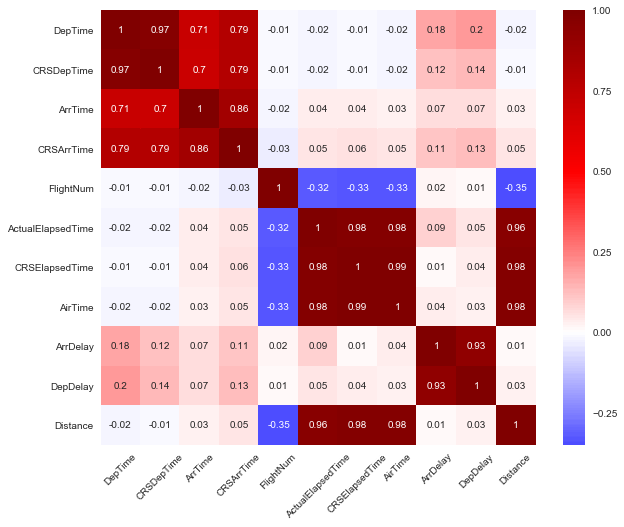

In [91]:
def plot_corr_matr(df, figsize=(10, 8)):
    """
    Plot Correlation matrix using Seaborns heatmap

    Parameters
    ----------
    df: pandas.DataFrame

    figsize: tuple
        size of the whole plot
    """
    plt.figure(figsize=figsize)
    corr = df.corr().round(2)
    # mask = np.zeros_like(corr)
    # mask[np.triu_indices_from(mask)] = True
    # Viet tat seaborn as sns
    sns.heatmap(
        corr,
        cmap="seismic",
        square=True,
        xticklabels=corr.columns.values,
        yticklabels=corr.columns.values,
        center=0,
        annot=True)
    plt.xticks(rotation=45)
    plt.show()
    
plot_corr_matr(df.loc[:,'DepTime':'Distance'])
# plot_corr_matr(df)

//////// _From the graph above, which features, in your opinions, should be removed, which should be kept, why?_

## 1st

-To classify whether a flight is late or not, choose __ArrTime as the label__.

-__ArrTime__, and __DepTime__ although have high correlation (0.72) but still not enough, we leave it to PCA to eliminate collinearity.

-__CRSArrTime__ and __ArrTime__ also has 0.87 correlation score, we just keep __ArrTime__ as it is the real time data.

-__ActualElapsedTime, CRSElapedTime, AirTime__ and __Distance__ have very high correlation (>0.95) so we can just keep one feature (Distance) as predictor.

-__CRSDepTime__ and __DepTime__ also has 0.97 correlation score, we just keep __DepTime__ as it is the real time data.

-__DepDelay__ is a predictor and __ArrDelay__ is a lable. __DepDelay__ and __ArrDelay__ have very high correlation (0.93).
So we want to see if other features can be a good predictors to ArrDelay, __delete DepDelay is the choice__.










In [92]:
# delete CRSDepTime, CRSArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, DepDelay
del df['CRSDepTime']
del df['CRSArrTime']
del df['ActualElapsedTime']
del df['CRSElapsedTime']
del df['AirTime']
del df['DepDelay']

In [93]:
# Loc cac mau tin sau khi loai bo CRSDepTime, CRSArrTime, ActualElapsedTime, CRSElapsedTime, AirTime, DepDelay
df = df.loc[:,'DepTime':'Distance']

////////// End the 1st request

<center>Table: Describe database</center>

In [94]:
# Hien thi dac tinh
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DepTime,441304,NaN,NaN,NaN,1333.03,477.991,1,928,1325,1727,2400
ArrTime,440370,NaN,NaN,NaN,1480.9,504.815,1,1107,1512,1908,2400
UniqueCarrier,450000,20,WN,76815,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FlightNum,450000,NaN,NaN,NaN,2221.48,1958.52,1,623,1569,3512,7829
TailNum,444581,5305,N485HA,305,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,440172,NaN,NaN,NaN,8.12522,38.6112,-86,-10,-2,12,1337
Origin,450000,301,ATL,26563,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Dest,450000,301,ATL,26742,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Distance,450000,NaN,NaN,NaN,725.162,561.382,24,325,580,950,4962


## 1.2. NaN Cleaning

<center>Table: Recheck describe columns with NaN values</center>

In [95]:
from IPython.display import display
import pandas as pd
def desc_nan(df):
    """
    Show a table that describe about all columns of @df that contain NaN.
    Hien thi 1 bang mieu ta tat ca cac cot, bao gom ca NaN
    
    """
    row, col = df.shape #Get shape
    nas = row - df.describe(include='all').T['count']
    nas = nas[nas > 0]
    ps = nas / row * 100
    ms = df.mode().iloc[0]
    nadf = pd.DataFrame(data={
        'Na Count': nas,
        'Na Percentage': ps,
        'mode': ms
    }).loc[nas.index]
    dnadf = df.describe().T.reindex(nadf.index)
    nadf = pd.concat([nadf, dnadf.iloc[:, 1:]], axis=1) #Noi cac du lieu cau truc pandas
    display(nadf)

desc_nan(df)

,Na Count,Na Percentage,mode,mean,std,min,25%,50%,75%,max
DepTime,8696,1.93244,555,1333.030804,477.990830,1.0,928.0,1325.0,1727.0,2400.0
ArrTime,9630,2.14,1020,1480.901621,504.814718,1.0,1107.0,1512.0,1908.0,2400.0
TailNum,5419,1.20422,N485HA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,9828,2.184,-5,8.125217,38.611189,-86.0,-10.0,-2.0,12.0,1337.0


<center>Figure: Distribution plot of all numeric columns</center>

In [96]:
def plot_ft_dist(df, fig_height=4, no_of_col=2,verbose=True):
    """
    Plot distribution of all numeric columns in df (Phan phoi bieu do cua tat ca cac cot so)

    Parameters
    ----------
    df: pandas.DataFrame

    fig_height: int

    no_of_col: int
    """
    df = df.copy()
    # prepare df
    cat_cols = list(df.dtypes[df.dtypes == 'object'].index)
    if verbose: # Neu dai dong bo qua cac cot phan loai
        print("Ignored categorical columns: ", cat_cols)
        print("")
    df_hasnan = df.isna().any().any()
    if df_hasnan:# 
        nan_cols = list(df.loc[:,df.isna().any()].columns)
        df.dropna(inplace=True, axis=1)
        if verbose:
            print("dropped NaN cols:", str(nan_cols))
            print("")
    try:    
        desc = df.describe().T
        std0 = list(desc.loc[desc['std']==0].index)
        if verbose:
            print("dropped std=0 cols:", str(std0))
            print("")
        for col in std0:
            del df[col]
    except KeyError:
        pass
    
    idx = df.dtypes[df.dtypes != 'object'].index
    # prepare frame
    f, axes = plt.subplots(
        int(np.ceil(len(idx) / no_of_col)),
        no_of_col,
        figsize=(5 * no_of_col, np.ceil(len(idx) / no_of_col) * fig_height))
    sns.set(style="white", palette="muted", color_codes=True)
    n = 0
    for i in idx:
        sns.distplot(
            df[i],
            color='b',
            hist=True,
            kde_kws={"shade": True},
            ax=axes[n // no_of_col, n % no_of_col])
        n += 1
    plt.show()
    
#plot_ft_dist(df)

////// _Run codes above, describe what you see and start clean data / remove unimportant columns._

## 2nd 

In [97]:
desc_nan(df)

,Na Count,Na Percentage,mode,mean,std,min,25%,50%,75%,max
DepTime,8696,1.93244,555,1333.030804,477.990830,1.0,928.0,1325.0,1727.0,2400.0
ArrTime,9630,2.14,1020,1480.901621,504.814718,1.0,1107.0,1512.0,1908.0,2400.0
TailNum,5419,1.20422,N485HA,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ArrDelay,9828,2.184,-5,8.125217,38.611189,-86.0,-10.0,-2.0,12.0,1337.0


In [98]:
# drop rows where DepTime or ArrTime is na
df.drop(df[df.DepTime.isna()].index, inplace = True)
df.drop(df[df.ArrTime.isna()].index, inplace = True)
df.drop(df[df.TailNum.isna()].index, inplace = True)
df.drop(df[df.ArrDelay.isna()].index, inplace = True)

Ignored categorical columns:  ['UniqueCarrier', 'TailNum', 'Origin', 'Dest']

dropped std=0 cols: []



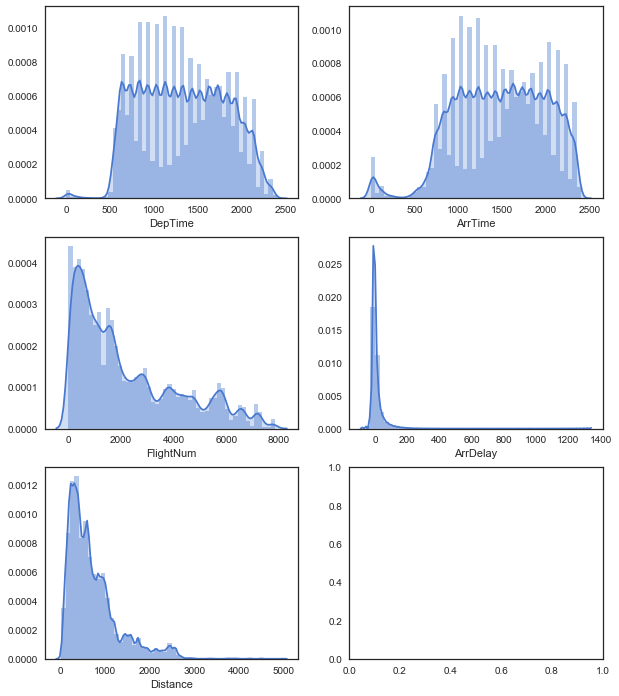

In [99]:
plot_ft_dist(df)

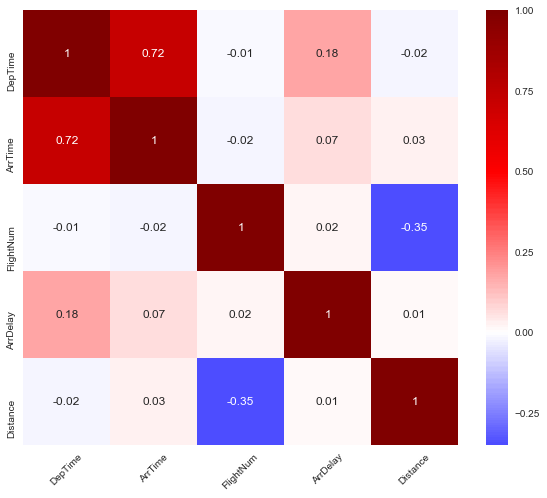

In [100]:
plot_corr_matr(df)

////////// End the 2nd request

<center>Table: (sample) Database after cleaning</center>

In [101]:
df.head(2)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,1118.0,1133.0,EV,4654,N981EV,17.0,ATL,MOB,302
1,1358.0,1953.0,CO,1848,N39343,-7.0,SJC,IAH,1608


## 1.3. Feature Engineering

/////////// Give some insights, split train-test dataset




### 1.3.1 Data Transformation

__DepTime, ArrTime__ are time values which if being stored in 10-based (decimal), their true values will be distorted (hours:minutes is not continuous on 10-based).
#=> convert to minute integer

In [102]:
# convert column to min:
def to_min(n):
    n = str(int(n))
    if len(n)<=2:
        return int(n)
    else:
        return int(n[:-2])*60+int(n[2:])
df.DepTime=df.DepTime.apply(to_min)
df.ArrTime=df.ArrTime.apply(to_min)

Convert all float dtype columns to int64 dtype

In [103]:
for col in df.columns:
    if df[col].dtype == np.float:
        df[col] = df[col].astype(np.int64)

<center>Table: (sample) Dataframe after dtype convertion</center>

In [104]:
dtypes = pd.Series(df.dtypes,name='dtypes')
df.head(2).append(dtypes)

,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,ArrDelay,Origin,Dest,Distance
0,678,693,EV,4654,N981EV,17,ATL,MOB,302
1,838,1193,CO,1848,N39343,-7,SJC,IAH,1608
dtypes,int64,int64,object,int64,object,int64,object,object,int64


### 1.3.2. One-hot-encoding

In order to pick which feature to use One-hot-encoding, we see how many unique data in each category data, then use boxplot to check the variation of ArrDelay by those features.
<br><br>
<center>Table: Unique value from each categorial feature</center>

In [105]:
pd.DataFrame(df.describe(include="O").loc['unique']).T

,UniqueCarrier,TailNum,Origin,Dest
unique,20,5295,301,301


/////// _start your code below to one hot encode or label encoding categorical features_

## 3rd




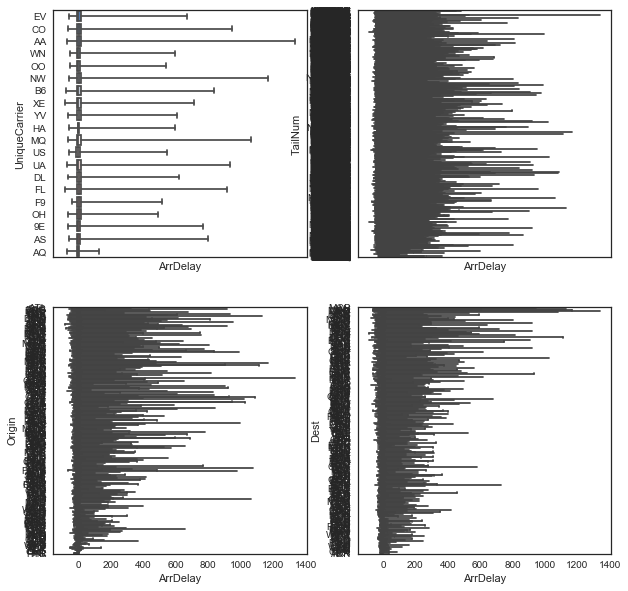

In [106]:
sns.set(style="white")
f, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2,2,sharex=True, squeeze=True, 
                                figsize=(10,10))

sns.boxplot(x="ArrDelay", y="UniqueCarrier", data=df,
            whis=np.inf, palette="vlag",ax=ax1)

sns.boxplot(x="ArrDelay", y="TailNum", data=df,
            whis=np.inf, palette="vlag",ax=ax2)

sns.boxplot(x="ArrDelay", y="Origin", data=df,
            whis=np.inf, palette="vlag",ax=ax3)

sns.boxplot(x="ArrDelay", y="Dest", data=df,
            whis=np.inf, palette="vlag", ax=ax4)
plt.show()

We assume that each __TailNum__ belongs to 1 __UniqueCarrier__. How late a flight is seems to more dependent on __UniqueCarrier__ than the __TailNum__. But we need to check this hypothesis by showing if there is any __TailNum__ that is NOT operated by 1 __UniqueCarrier__.
<br><br>
<center>Table: TailNum that is not operated by one UniqueCarrie</center>

In [107]:
# Check if there is any TailNum that belongs to 2 UniqueCarriers
pd.DataFrame(df.groupby('TailNum').UniqueCarrier.unique()
                [df.groupby('TailNum').UniqueCarrier.unique()
                     .apply(lambda x: len(x)!=1)])

,UniqueCarrier
TailNum,
N376CA,"[EV, OH]"
N379CA,"[EV, OH]"


The table rejects our hypothesis, but it shows only 2 instances of __TailNum__.
The total number of records of N376CA and N379CA is 3171/6855024 (0.0462%) which is a very small affect (if any) on the prediction result. In addition, the amount of unique __TailNum__ is too large (5366) that might result in not having enough samples for each unique __TailNum__ (which makes the result more unreliable)

__Origin__ or __Dest__ can be reliable predictors but currently we skip these rows for computational benefits.

After finish analyzing those 4 categorial features, only 1 column to one-hot-encode is __UniqueCarrier__.

In [108]:
# one-hot-encode UniqueCarrier column
carrier = pd.get_dummies(df.UniqueCarrier)
carrier.reset_index(drop=True, inplace=True)

////////// End the 3rd request

## 2.2. Normalize data

/////// _normalize / scale your data to range [0,1]

## 4th



Because of feature scaling, new table of normalized data (in range [0,1]) is needed.

In [109]:
# delete categorical data:
for col in df.columns:
    if df[col].dtype == np.object:
        del df[col]

# Normalize the df
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(df)
X = pd.DataFrame(X, columns=df.columns)

In [110]:
# combine normalized data with one-hot-encoded columns
X = X.join(carrier)

In [111]:
# assign ArrDelay in format of boolean, True if ArrDelay > 30 minutes
Y = df.ArrDelay>30
Y.reset_index(drop=True, inplace=True)
del df['ArrDelay']

////////// End the 4th request

<center>Table: (sample) Predictor X (without PCA)

In [112]:
X[:2]

,DepTime,ArrTime,FlightNum,ArrDelay,Distance,9E,AA,AQ,AS,B6,CO,DL,EV,F9,FL,HA,MQ,NW,OH,OO,UA,US,WN,XE,YV
0,0.470466,0.480890,0.594405,0.072382,0.056298,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0.581654,0.828353,0.235948,0.055517,0.320778,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 2.3. PCA

<center>Figure: Explaination ratio though dimensions using PCA and Cumulative explained variance table in details</center>

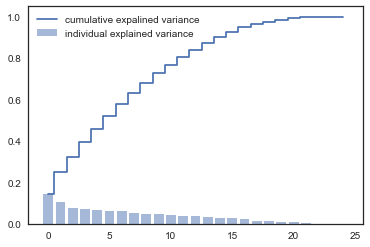

,dim 1,dim 2,dim 3,dim 4,dim 5,dim 6,dim 7,dim 8,dim 9,dim 10,dim 11,dim 12,dim 13,dim 14,dim 15,dim 16,dim 17,dim 18,dim 19,dim 20,dim 21,dim 22,dim 23,dim 24,dim 25
0,0.14367,0.249683,0.32389,0.393913,0.460072,0.519662,0.579059,0.631625,0.680376,0.725793,0.767565,0.804265,0.839812,0.872987,0.900893,0.927966,0.94916,0.963097,0.97454,0.984182,0.99261,0.998208,0.999356,1.0,1.0


In [113]:
def plot_PCA(df):
    """
    Show the "PCA ladder" in order to pick the right

    Parameters
    ----------
    df: pandas.DataFrame

    fig_height: int

    no_of_col: int
    """
    from sklearn.decomposition import PCA

    pca = PCA(n_components=len(df.columns))
    pca.fit_transform(df)
    # put data (predictor only) to pca and create pcadf
    ratio = pca.explained_variance_ratio_

    tot = sum(ratio)
    var_exp = [(i / tot) for i in ratio]
    cum_var_exp = np.cumsum(var_exp)

    plt.bar(
        range(0, len(df.columns)),
        var_exp,
        alpha=0.5,
        align='center',
        label='individual explained variance')
    plt.step(
        range(0, len(df.columns)),
        cum_var_exp,
        where='mid',
        label='cumulative expalined variance')
    plt.ylabel = 'Explained variance ratio'
    plt.xlabel = 'Pricipal components'
    plt.legend(loc='best')
    plt.show()

    # show table with more details
    pdf = pd.DataFrame(
        [cum_var_exp],
        columns=["dim {}".format(i) for i in range(1,
                                                   len(df.columns) + 1)])
    display(pdf)
    
    
plot_PCA(X)

//////////// the code below has "n" as dimensions to reduce to, decide that number so the total explation ratio > 0.95

## 5th




In [114]:
from sklearn.decomposition import PCA
# create a PCA to reduce dimension to n
n = 18
pca = PCA(n_components=n)
# put data (predictor only) to pca and create pcadf
X = pd.DataFrame(pca.fit_transform(X))

In [115]:
# get random 100_000 samples records from full dataset to tune
x_tune = X.sample(n=100_000, random_state=25)
y_tune = Y.sample(n=100_000, random_state=25)

# get random 1_250_000 samples records from full dataset
# that differ from the x_100k and y_100k
x = (X[~X.index.isin(x_tune.index)]
        .sample(n=1_250_000, random_state=25))
y = (Y[~Y.index.isin(x_tune.index)]
        .sample(n=1_250_000, random_state=25))

SyntaxError: invalid syntax (<ipython-input-115-f87d4508cd93>, line 2)

In [ ]:
# prepare the train and test data.
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
                        x, y, test_size=0.2, random_state=25)

//////// End the 5th request

In [ ]:
# Save processed database to a csv file
import os
os.chdir(r'.\working_database')

x_tune.to_csv('x_tune.csv')
pd.DataFrame(y_tune).to_csv('y_tune.csv')
x_train.to_csv('x_train.csv')
pd.DataFrame(y_train).to_csv('y_train.csv')
x_test.to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')

os.chdir('..')

# 3. Classification Models

In [ ]:
# import neccessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# show plot intermediately under the calling cell
%matplotlib inline

# disable some warnings
import warnings
warnings.simplefilter(action = "ignore")

# set to unlimited column display:
pd.set_option('display.max_columns', None)

# Load processed database from a csv file
import os
os.chdir(r'.\working_database')

x_tune = pd.read_csv('x_tune.csv', index_col=0)
y_tune = pd.read_csv('y_tune.csv', index_col=0)
x_train = pd.read_csv('x_train.csv', index_col=0)
y_train = pd.read_csv('y_train.csv', index_col=0)
x_test = pd.read_csv('x_test.csv', index_col=0)
y_test = pd.read_csv('y_test.csv', index_col=0)

os.chdir('..')

The following model will use default parameters and sample classification report

## 3.1. Naive Bayes

Initialize the model and fit the train database

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(x_train, y_train)

In [ ]:
from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

////// Search google for "sklearn logistics regression" / decision tree / svm and figure out how to work on below parts

## 6th



## 3.2. Logistics Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='l2', # 'l1'
                        C = 1.0) # float

In [ ]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
C_list = [0.1, 1, 10, 100, 1000]
penalty_list = ['l1','l2']
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']

# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                 penalty=penalty_list,
                 solver=solver_list)
# Instantiate the grid:
grid = GridSearchCV(lr, param_grid, cv=10, error_score=0.0,
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=0.1,
                        penalty='l1',
                        solver='liblinear')
lr.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=lr.predict(x_test)))

## 3.3. Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='gini', # 'entropy'
                             min_samples_leaf=1, # float
                             class_weight=None # 'balance'
                             ) 
# tree.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import GridSearchCV
# Defind the parameter values that should be searched
criterion_list = ['gini','entropy']
min_samples_leaf_list = [1,2,4,6,8,10]
class_weight_list = [None,'balanced']
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(criterion=criterion_list,
                 min_samples_leaf=min_samples_leaf_list,
                 class_weight=class_weight_list)

# Instantiate the grid:
grid = GridSearchCV(tree, param_grid, cv=10, 
                    scoring='f1_weighted', n_jobs=16)

# fit the grid with data
grid.fit(x_tune, y_tune)

# examine the best model
print(grid.best_score_)
print(grid.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(grid.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in grid.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',
                              min_samples_leaf=2,
                              class_weight=None)
                              
tree.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=nb.predict(x_test)))

## 3.4. SVM

In [ ]:
from sklearn.svm import SVC
svm = SVC(C = 1.0,       # float
         kernel = 'rbf', # 'linear','poly', 'sigmoid'
         gamma = 'auto') # float
# svm.fit(x_train, y_train)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Defind the parameter values that should be searched
C_list = [1,10,100,1000]
kernel_list = ['rbf','linear','poly','sigmoid']
gamma_list = ['auto', 10, 0.2]
# Create a parameter grid: map the parameter names to the
# values that should be searched:
param_grid = dict(C=C_list,
                  kernel=kernel_list,
                  gamma=gamma_list)

# Instantiate the rand:
rand = RandomizedSearchCV(svm, param_grid, cv=5, 
                         scoring='f1_weighted', n_jobs=16,
                         n_iter=5, random_state=25)

# fit the rand with data
rand.fit(x_tune, y_tune)

# examine the best model
print(rand.best_score_)
print(rand.best_params_)

# gre = Gridsearchcv REsult
gre = pd.DataFrame(rand.cv_results_)
(gre.loc[gre.mean_test_score!=0] # skip zero scored rows
     [['rank_test_score','mean_fit_time','mean_test_score'] # get these col
          +['param_{}'.format(i) for i in rand.best_params_.keys()]]
    .sort_values('rank_test_score')) # sort by rank

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf')               
svm.fit(x_train, y_train)

from sklearn.metrics import classification_report
print('Classification_report: \n', 
      classification_report(
          y_true=y_test,
          y_pred=svm.predict(x_test)))

////////// End the 6th request

# Z. Other
Additional parts

## Z.1. Pickle

In [ ]:
# Save a model into a pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
pickle.dump(svm, open( "svm.model", "wb" ) )
os.chdir('..')

In [ ]:
# Load the model back from the pickle file.
import pickle
import os
os.chdir(r'.\saved_models')
lr = pickle.load(open("lr.model", "rb"))
nb = pickle.load(open("nb.model", "rb"))
rf = pickle.load(open("rf.model", "rb"))
tree = pickle.load(open("tree.model", "rb"))
svm = pickle.load(open("svm.model", "rb"))
os.chdir('..')